Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9


Wrote a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, November 26 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, November 27
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [440]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy
from sklearn.cluster import KMeans
import itertools

from utils.reproduce_functions import *
from utils.mutation_functions import *
from utils.parent_selection_functions import *
from utils.other_fucntions import *
from utils.island_functions import *

import lab9_lib

In [441]:
MU = 5 #10
MU_INIT = MU #10
LAMBDA = 30 #10
MUTATION_PROB = 0.2

SKIP_VISITED = False # Memoisation skip=True, Reuse=False

NUMBER_GENERATIONS = 3_000
K_POPULATIONS = 1 #5
K_POPULATIONS_INIT = K_POPULATIONS #5
CLUSTER_TIMES = NUMBER_GENERATIONS//K_POPULATIONS #10
#15k

LENGTH_SOLUTION = 1000

In [442]:
mutate = one_bit_flip
reproduce = uniform_crossover
parent_selection = roulette
island_swap_func = swap_individuals_between_islands

In [443]:
fitness = lab9_lib.make_problem(5)
parents = [generate_random_individual() for _ in range(2*K_POPULATIONS*MU)]
parents_eval = [fitness(x) for x in parents]

tot_created = len(parents)
pop_history = {}
for i in range(len(parents)):
    pop_history[parents[i].tobytes()] = parents_eval[i]

### Segregate the populations
kmeans = KMeans(n_clusters=K_POPULATIONS)
parent_labels = kmeans.fit(parents).labels_

# Put every individual in its population
populations = [[] for _ in range(K_POPULATIONS)]
population_evals = [[] for _ in range(K_POPULATIONS)]

for i in range(len(parents)):
    populations[ parent_labels[i] ].append( parents[i] )
    population_evals[ parent_labels[i] ].append( parents_eval[i] )


# Every population has its own fitnesses

hist_mean = []
hist_std = []
div = []
gen_cluster_merge = []

tot_evaluated = len(parents)


for generation in tqdm(range(NUMBER_GENERATIONS)):
    # offsprings = []
    # offsprings_evals = []

    # if (max(parents_evals)-min(parents_evals)) > 1e-5:
    #     probabilities = [(score-min(parents_evals)) / (max(parents_evals)-min(parents_evals)) for score in parents_evals]
    # else:
    #     probabilities = [1 for score in parents_evals]
    # probabilities = np.array(probabilities)/sum(probabilities)
    

    
    offsprings = [[] for i in range(K_POPULATIONS)]
    offsprings_evals = [[] for i in range(K_POPULATIONS)]
    for i_population in range(K_POPULATIONS):
        while len(offsprings[i_population]) < LAMBDA//K_POPULATIONS:
            parents = populations[i_population]
            probabilities = population_evals[i_population]

            p1 = random.choices(parents, k=1, weights=probabilities)[0] # TO CHECK WEIGHTS
            p2 = random.choices(parents, k=1, weights=probabilities)[0]
            
            div_parents = np.sum( np.abs( p1-p2 ) )
            div_threshold = 20
            indexes_to_change = [i for i in range(len(p1)) if p1[i] == p2[i]]

            new_ind = mutate(reproduce1(p1,p2), 
                            # The more diverse the parents are, the more I mutate them >>> Exploration
                            size=random.choice([1,1]),#+int( min(div_parents,30) / 10 ), \
                            # The more similar the more the probability to mutate
                            mutation_probability=(MUTATION_PROB),#+(1-MUTATION_PROB)*(1-(min(div_threshold,div_parents)/div_threshold)),
                            indexes_to_change=indexes_to_change)
            tot_created += 1

            new_ind_eval = pop_history.get(new_ind.tobytes())
            if new_ind_eval == None:
                new_ind_eval = fitness(new_ind)
                pop_history[new_ind.tobytes()] = new_ind_eval
            elif new_ind_eval != None and SKIP_VISITED:
                continue
                
            offsprings[i_population].append(new_ind)
            offsprings_evals[i_population].append(new_ind_eval)

            
    all_people = [offsprings[i] for i in range(K_POPULATIONS)]
    all_evals = [offsprings_evals[i] for i in range(K_POPULATIONS)]

    # Select new parents
    best_people = [np.argsort(all_evals[i])[::-1] for i in range(K_POPULATIONS)]

    populations = [[] for i in range(K_POPULATIONS)]
    population_evals = [[] for i in range(K_POPULATIONS)]
    for k in range(K_POPULATIONS):
        for i in range(min( int(MU_INIT*(K_POPULATIONS_INIT/K_POPULATIONS)), len(all_people[k]))):
            populations[k].append( all_people[k] [ best_people[k][i] ] )
            population_evals[k].append( all_evals[k] [ best_people[k][i] ] )

    # if (generation+1) % CLUSTER_TIMES == 0 and K_POPULATIONS > 1:
    #     clusters = []
    #     for k in range(K_POPULATIONS):
    #         c = np.array(populations[k]).mean(axis=0)
    #         clusters.append(c)
    #     fitnesses = []
    #     for k in range(K_POPULATIONS):
    #         f = np.mean(population_evals[k])
    #         fitnesses.append(f)
        

    #     min_dist = float('inf')
    #     min_cluster_distance = (-1,-1)
    #     for i in range(len(clusters)):
    #         for j in range(i, len(clusters)):
    #             dist = np.sum(np.abs(clusters[i]-clusters[j]))
    #             if dist < min_dist:
    #                 min_dist = dist
    #                 min_cluster_distance = (i,j)
        
    #     i, j = min_cluster_distance
    #     populations[i] = populations[i].extend(populations[j])
    #     populations.pop(j)
    #     population_evals[i] =  population_evals[i].extend(population_evals[j])
    #     population_evals.pop(j)
    #     K_POPULATIONS = max(1, K_POPULATIONS-1)
    #     gen_cluster_merge.append(generation)


    if ((generation+1) % CLUSTER_TIMES) == 0 and K_POPULATIONS > 1:
        parents = []
        evals = []
        for k in range(K_POPULATIONS):
            parents = parents + populations[k]
            evals = evals + population_evals[k]

        K_POPULATIONS = max(1, K_POPULATIONS-1)
        gen_cluster_merge.append(generation)
        
        ### Segregate the populations
        kmeans = KMeans(n_clusters=K_POPULATIONS, n_init='auto')
        parent_labels = kmeans.fit(parents).labels_

        # Put every individual in its population
        populations = [[] for _ in range(K_POPULATIONS)]
        population_evals = [[] for _ in range(K_POPULATIONS)]
        for i in range(len(parents)):
            populations[ parent_labels[i] ].append( parents[i] )
            population_evals[ parent_labels[i] ].append( evals[i] )

    ### INFOS
    hist_mean.append(np.max(
            list(itertools.chain.from_iterable(all_evals))
        ))
    hist_std.append(np.std(
        list(itertools.chain.from_iterable(all_evals))  
    ))
    # div.append(get_diversity(parents))

i_best = np.argmax( list(itertools.chain.from_iterable(population_evals)) )
#print(parents[i_best])

print("Best score: ", list(itertools.chain.from_iterable(population_evals))[i_best])
print("Num fitness calls: ", fitness.calls)
print("Evaluated agents:", len(pop_history.items()))
print("Total agents:", tot_created)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  0%|          | 2/3000 [00:00<02:50, 17.55it/s]

100%|██████████| 3000/3000 [00:54<00:00, 54.84it/s]

Best score:  1.0
Num fitness calls:  9072
Evaluated agents: 9072
Total agents: 90010


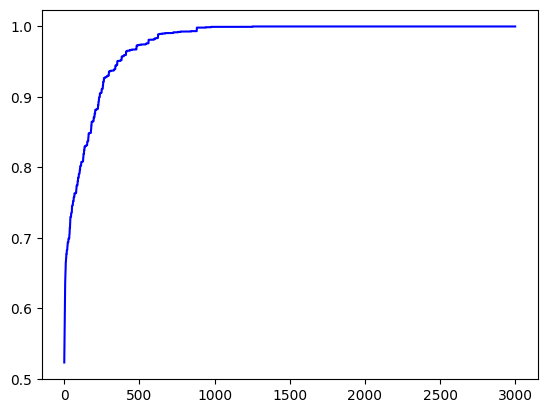

In [444]:
import matplotlib.pyplot as plt

hist_mean = np.array(hist_mean)
hist_std = np.array(hist_std)

plt.plot(hist_mean, c='blue')
plt.scatter(gen_cluster_merge, [hist_mean[i] for i in gen_cluster_merge], color="orange")
# plt.plot(hist_mean+hist_std, c='red', alpha=0.5)
# plt.plot(hist_mean-hist_std, c='red', alpha=0.5)
plt.show()

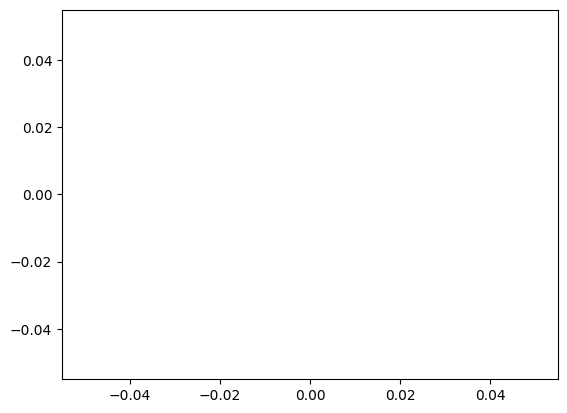

In [445]:

plt.plot(div[30:])
plt.show()

In [446]:
a = [[3],[12,23],[3]]

sum([len(x) for x in a])

4